In [126]:
import warnings
warnings.filterwarnings('ignore')
import random

import torch
from torch import nn 
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix


import pandas as pd
import matplotlib.pyplot as plt

from timeit import default_timer as timer 
from tqdm import tqdm

In [42]:
train_data = datasets.FashionMNIST(
    root="data",
    train=True, 
    download=True, 
    transform=ToTensor(), 
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [43]:
len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)

(60000, 60000, 10000, 10000)

In [44]:
train_data.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [45]:
image, label = train_data[0]
print(image.shape, image.dtype, label) #NCHW

torch.Size([1, 28, 28]) torch.float32 9


Text(0.5, 1.0, '9')

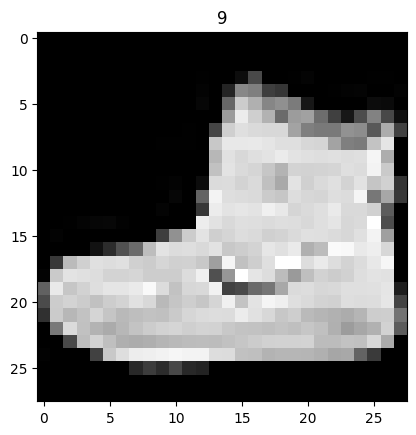

In [46]:
plt.imshow(image.squeeze(), cmap='gray')
plt.title(label)

In [47]:
BATCH_SIZE = 32

train_dataloader = DataLoader(train_data, 
                              batch_size=BATCH_SIZE,
                              shuffle=True
)
test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False
)
print(len(train_dataloader.dataset))
print(f"Train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

60000
Train dataloader: 1875 batches of 32
Test dataloader: 313 batches of 32


In [48]:
# NCHW
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [62]:
# model 0 
class VanillaModel(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units), # in_features will be H X W
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )
    
    def forward(self, x):
        return self.layer_stack(x)

In [65]:
# model 1
class NonLinearModel(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )
    
    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

In [64]:
def compute_accuracy(y_true, y_pred):
    tp_tn = torch.eq(y_true, y_pred).sum().item()
    acc = (tp_tn / len(y_pred)) * 100 
    return acc


def print_train_time(start: float, end: float, device: torch.device = None):
    torch.mps.synchronize()
    total_time = end - start
    print(f"Train time on {device}: {total_time:.2f} seconds")
    return total_time

In [50]:
torch.manual_seed(42)

model_0 = VanillaModel(input_shape=image.shape[1]*image.shape[2],
                       hidden_units=10,
                       output_shape=len(train_data.classes)
)
model_0.to("cpu")

VanillaModel(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [80]:
print(str(next(model_0.parameters()).device))

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu
cpu


In [52]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [69]:
train_time_start = timer()
epochs = 10

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}")

    # Training
    train_loss = 0 
    
    for batch, (X, y) in enumerate(train_dataloader):
        model_0.train() 
    
        y_pred = model_0(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(train_dataloader)
    
    # Testing
    test_loss = 0
    test_acc = 0 
    model_0.eval()

    with torch.inference_mode():
        for X, y in test_dataloader:
            
            test_pred = model_0(X)
            test_loss += loss_fn(test_pred, y)
            test_acc += compute_accuracy(y_true=y, y_pred=test_pred.argmax(dim=1))
        
        # per batch
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)

    print(f"\nTraining loss: {train_loss:.5f} | Testing loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")


train_time_end = timer()
train_time_model_0 = print_train_time(start=train_time_start, 
                                      end=train_time_end,
                                      device=str(next(model_0.parameters()).device))

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0


 10%|█         | 1/10 [00:01<00:14,  1.66s/it]


Training loss: 0.40684 | Testing loss: 0.48635, Test acc: 82.22%

Epoch: 1


 20%|██        | 2/10 [00:03<00:13,  1.65s/it]


Training loss: 0.40684 | Testing loss: 0.48635, Test acc: 82.22%

Epoch: 2


 30%|███       | 3/10 [00:04<00:11,  1.63s/it]


Training loss: 0.40684 | Testing loss: 0.48635, Test acc: 82.22%

Epoch: 3


 40%|████      | 4/10 [00:06<00:09,  1.65s/it]


Training loss: 0.40684 | Testing loss: 0.48635, Test acc: 82.22%

Epoch: 4


 50%|█████     | 5/10 [00:08<00:08,  1.64s/it]


Training loss: 0.40684 | Testing loss: 0.48635, Test acc: 82.22%

Epoch: 5


 60%|██████    | 6/10 [00:09<00:06,  1.62s/it]


Training loss: 0.40684 | Testing loss: 0.48635, Test acc: 82.22%

Epoch: 6


 70%|███████   | 7/10 [00:11<00:04,  1.62s/it]


Training loss: 0.40684 | Testing loss: 0.48635, Test acc: 82.22%

Epoch: 7


 80%|████████  | 8/10 [00:13<00:03,  1.62s/it]


Training loss: 0.40684 | Testing loss: 0.48635, Test acc: 82.22%

Epoch: 8


 90%|█████████ | 9/10 [00:14<00:01,  1.63s/it]


Training loss: 0.40684 | Testing loss: 0.48635, Test acc: 82.22%

Epoch: 9


100%|██████████| 10/10 [00:16<00:00,  1.63s/it]


Training loss: 0.40684 | Testing loss: 0.48635, Test acc: 82.22%

Train time on cpu: 16.27 seconds


In [82]:
def evaluate_model(model: torch.nn.Module, 
                   data_loader: torch.utils.data.DataLoader, 
                   loss_fn: torch.nn.Module, 
                   accuracy_fn,
                   device: torch.device = device):
    """
    Returns a dictionary containing the results of model predicting on data_loader.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss = 0
    acc = 0
    model.eval()
    
    with torch.inference_mode():
        for X, y in data_loader:
            # send data to the target device
            X, y = X.to(device), y.to(device)

            y_pred = model(X)
            
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        
        # per batch
        loss /= len(data_loader)
        acc /= len(data_loader)
        
    return {"model_name": model.__class__.__name__,
            "model_loss": loss.item(),
            "model_accuracy": acc}


In [83]:
# model 0 results on test set
model_0_results = evaluate_model(model=model_0, 
                                 data_loader=test_dataloader,
                                 loss_fn=loss_fn, 
                                 accuracy_fn=compute_accuracy,
                                 device=device
)
model_0_results

{'model_name': 'VanillaModel',
 'model_loss': 0.4863521456718445,
 'model_accuracy': 82.21845047923323}

In [84]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

# using M chip Mac
if torch.backends.mps.is_available():
   device = torch.device("mps")
   x = torch.ones(1, device=device)
   print(x)
else:
   print("MPS device not found.")

cpu
tensor([1.], device='mps:0')


In [85]:
torch.manual_seed(42)

model_1 = NonLinearModel(input_shape=image.shape[1]*image.shape[2],
                         hidden_units=10,
                         output_shape=len(train_data.classes)
).to(device) # send model to GPU if it's available

print(str(next(model_1.parameters()).device))

mps:0


In [86]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

In [87]:
def train_model(model: torch.nn.Module,
                data_loader: torch.utils.data.DataLoader,
                loss_fn: torch.nn.Module,
                optimizer: torch.optim.Optimizer,
                accuracy_fn,
                device: torch.device = device):

    # Training
    train_loss = 0 
    train_acc = 0
    model.to(device)

    for batch, (X, y) in enumerate(data_loader):
        # send data to GPU
        X, y = X.to(device), y.to(device)
    
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(train_dataloader)
    train_acc /= len(data_loader)

    print(f"Training loss: {train_loss:.5f} | Training accuracy: {train_acc:.2f}%")


def test_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = device):
    
    # Testing
    test_loss = 0
    test_acc = 0 
    model.to(device)
    model_0.eval()

    with torch.inference_mode():
        for X, y in data_loader:
            # send data to GPU
            X, y = X.to(device), y.to(device)
            
            test_pred = model(X)
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
        
        # per batch
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)

    print(f"Testing loss: {test_loss:.5f} | Testing accuracy: {test_acc:.2f}%\n")

In [89]:
train_time_start = timer()
epochs = 10

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}")

    train_model(data_loader=train_dataloader, 
                model=model_1, 
                loss_fn=loss_fn,
                optimizer=optimizer,
                accuracy_fn=compute_accuracy
    )
    if epoch % 2 == 0:
        test_model(model=model_1,
                data_loader=test_dataloader,
                loss_fn=loss_fn,
                accuracy_fn=compute_accuracy
        )

train_time_end = timer()
train_time_model_1 = print_train_time(start=train_time_start, 
                                      end=train_time_end,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
Training loss: 0.84214 | Training accuracy: 70.16%


 10%|█         | 1/10 [00:06<00:56,  6.31s/it]

Testing loss: 0.71671 | Testing accuracy: 73.79%

Epoch: 1


 20%|██        | 2/10 [00:11<00:47,  5.88s/it]

Training loss: 0.67697 | Training accuracy: 75.44%
Epoch: 2
Training loss: 0.65150 | Training accuracy: 76.26%


 30%|███       | 3/10 [00:17<00:41,  5.98s/it]

Testing loss: 0.66602 | Testing accuracy: 75.82%

Epoch: 3


 40%|████      | 4/10 [00:23<00:34,  5.76s/it]

Training loss: 0.63573 | Training accuracy: 76.72%
Epoch: 4
Training loss: 0.62549 | Training accuracy: 77.06%


 50%|█████     | 5/10 [00:29<00:29,  5.93s/it]

Testing loss: 0.65772 | Testing accuracy: 75.78%

Epoch: 5


 60%|██████    | 6/10 [00:35<00:23,  5.83s/it]

Training loss: 0.61992 | Training accuracy: 77.16%
Epoch: 6
Training loss: 0.61418 | Training accuracy: 77.24%


 70%|███████   | 7/10 [00:41<00:17,  5.92s/it]

Testing loss: 0.64065 | Testing accuracy: 76.59%

Epoch: 7


 80%|████████  | 8/10 [00:47<00:11,  5.87s/it]

Training loss: 0.60846 | Training accuracy: 77.46%
Epoch: 8
Training loss: 0.60431 | Training accuracy: 77.53%


 90%|█████████ | 9/10 [00:53<00:05,  5.97s/it]

Testing loss: 0.64988 | Testing accuracy: 76.40%

Epoch: 9


100%|██████████| 10/10 [00:59<00:00,  5.91s/it]

Training loss: 0.60098 | Training accuracy: 77.81%
Train time on mps: 59.09 seconds


In [90]:
# model 1 results on test set
model_1_results = evaluate_model(model=model_1, 
                                 data_loader=test_dataloader,
                                 loss_fn=loss_fn, 
                                 accuracy_fn=compute_accuracy,
                                 device=device
)

In [91]:
print(model_0_results)
print(model_1_results)

{'model_name': 'VanillaModel', 'model_loss': 0.4863521456718445, 'model_accuracy': 82.21845047923323}
{'model_name': 'NonLinearModel', 'model_loss': 0.6520592570304871, 'model_accuracy': 76.15814696485623}


# CNN - TinyVGG

In [102]:
test_images = torch.randn(size=(32, 3, 64, 64))
test_image = test_images[0]

conv_layer = nn.Conv2d(in_channels=3,
                         out_channels=10,
                         kernel_size=(5, 5),
                         stride=2,
                         padding=0)
max_pool_layer = nn.MaxPool2d(kernel_size=2)

print(test_image.shape)
print(conv_layer(test_image.unsqueeze(dim=0)).shape)
print(max_pool_layer(conv_layer(test_image.unsqueeze(dim=0))).shape)

torch.Size([3, 64, 64])
torch.Size([1, 10, 30, 30])
torch.Size([1, 10, 15, 15])


In [95]:
print(conv_layer.state_dict())

OrderedDict([('weight', tensor([[[[-1.0788e-01,  5.9426e-02,  1.1359e-03,  6.1827e-03, -1.4073e-02],
          [-1.6203e-02,  5.4726e-02, -7.6181e-02,  9.3466e-02, -8.5709e-02],
          [ 3.1117e-02,  4.7625e-02,  4.4068e-02,  5.2393e-02,  9.9105e-02],
          [-6.3450e-02,  1.1040e-01,  6.3507e-03,  6.3543e-02,  7.5569e-02],
          [ 1.7745e-02,  4.6209e-02,  7.0248e-02,  1.6617e-02,  1.0131e-01]],

         [[-2.6650e-02, -2.9258e-02,  3.3528e-03,  7.2465e-02,  6.8792e-02],
          [-8.5270e-02, -8.6530e-02,  4.1514e-02,  1.0900e-03,  6.0747e-02],
          [ 8.2494e-02,  9.1270e-02, -4.1793e-02, -6.9249e-02, -5.9285e-02],
          [-1.1438e-01, -5.1687e-03, -9.7562e-02, -7.5620e-02,  2.3226e-02],
          [-3.2276e-05,  6.9110e-03, -6.9991e-02, -2.9666e-02, -9.6323e-02]],

         [[-1.1511e-01,  9.6922e-02, -8.2784e-02, -9.7121e-02,  2.8138e-02],
          [-1.0416e-01,  1.0653e-01, -8.3826e-02,  7.3642e-02,  6.7204e-02],
          [ 4.4635e-02, -6.4581e-02, -9.3340e-02

In [101]:
# Get shapes of weight and bias tensors within conv_layer_2
print(f"conv_layer weight shape: {conv_layer.weight.shape}")
print(f"conv_layer bias shape: {conv_layer.bias.shape}")

conv_layer weight shape: torch.Size([10, 3, 5, 5])
conv_layer bias shape: torch.Size([10])


In [99]:
class TinyVGG(nn.Module):
    
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3,
                      stride=1,
                      padding=1),# options are "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2) # stride will be same as kernel size 
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7, 
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.fc(x)
        # print(x.shape)
        return x


In [123]:
print(device)

mps


In [100]:
model_2 = TinyVGG(input_shape=1, 
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device)
model_2

TinyVGG(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [103]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)

In [104]:
train_time_start2 = timer()
epochs = 10

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}")

    train_model(data_loader=train_dataloader, 
                model=model_2, 
                loss_fn=loss_fn,
                optimizer=optimizer,
                accuracy_fn=compute_accuracy
    )
    if epoch % 2 == 0:
        test_model(model=model_2,
                data_loader=test_dataloader,
                loss_fn=loss_fn,
                accuracy_fn=compute_accuracy
        )

train_time_end2 = timer()
train_time_model_2 = print_train_time(start=train_time_start2, 
                                      end=train_time_end2,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
Training loss: 0.56179 | Training accuracy: 79.89%


 10%|█         | 1/10 [00:11<01:42, 11.40s/it]

Testing loss: 0.44999 | Testing accuracy: 83.87%

Epoch: 1


 20%|██        | 2/10 [00:20<01:18,  9.79s/it]

Training loss: 0.35251 | Training accuracy: 87.12%
Epoch: 2
Training loss: 0.31583 | Training accuracy: 88.58%


 30%|███       | 3/10 [00:29<01:07,  9.59s/it]

Testing loss: 0.33852 | Testing accuracy: 87.72%

Epoch: 3


 40%|████      | 4/10 [00:37<00:54,  9.15s/it]

Training loss: 0.29477 | Training accuracy: 89.32%
Epoch: 4
Training loss: 0.28279 | Training accuracy: 89.69%


 50%|█████     | 5/10 [00:47<00:46,  9.32s/it]

Testing loss: 0.30407 | Testing accuracy: 89.15%

Epoch: 5


 60%|██████    | 6/10 [00:56<00:36,  9.12s/it]

Training loss: 0.27007 | Training accuracy: 90.21%
Epoch: 6
Training loss: 0.26185 | Training accuracy: 90.46%


 70%|███████   | 7/10 [01:05<00:27,  9.26s/it]

Testing loss: 0.29719 | Testing accuracy: 89.26%

Epoch: 7


 80%|████████  | 8/10 [01:14<00:18,  9.20s/it]

Training loss: 0.25566 | Training accuracy: 90.68%
Epoch: 8
Training loss: 0.25026 | Training accuracy: 90.81%


 90%|█████████ | 9/10 [01:24<00:09,  9.28s/it]

Testing loss: 0.28047 | Testing accuracy: 89.60%

Epoch: 9


100%|██████████| 10/10 [01:32<00:00,  9.29s/it]

Training loss: 0.24461 | Training accuracy: 90.98%
Train time on mps: 92.92 seconds


In [106]:
# model 2 results on test set
model_2_results = evaluate_model(model=model_2, 
                                 data_loader=test_dataloader,
                                 loss_fn=loss_fn, 
                                 accuracy_fn=compute_accuracy,
                                 device=device
)

In [107]:
print(model_0_results)
print(model_1_results)
print(model_2_results)

{'model_name': 'VanillaModel', 'model_loss': 0.4863521456718445, 'model_accuracy': 82.21845047923323}
{'model_name': 'NonLinearModel', 'model_loss': 0.6520592570304871, 'model_accuracy': 76.15814696485623}
{'model_name': 'TinyVGG', 'model_loss': 0.27602726221084595, 'model_accuracy': 89.94608626198082}


In [111]:
results_df = pd.DataFrame([model_0_results, model_1_results, model_2_results])
results_df["training_time"] = [train_time_model_0, train_time_model_1, train_time_model_2]
results_df

,model_name,model_loss,model_accuracy,training_time
0,VanillaModel,0.486352,82.218450,16.274404
1,NonLinearModel,0.652059,76.158147,59.089668
2,TinyVGG,0.276027,89.946086,92.918005


In [112]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()

    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(device)

            # model output is logit
            pred_logit = model(sample)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
            pred_probs.append(pred_prob.cpu())
            
    return torch.stack(pred_probs)

In [114]:
test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({train_data.classes[test_labels[0]]})")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 5 (Sandal)


In [115]:
pred_probs= make_predictions(model=model_2, 
                             data=test_samples)

print(len(pred_probs))
print(pred_probs[0])

9
tensor([6.8725e-07, 4.2128e-09, 3.3301e-07, 1.1767e-06, 3.3763e-08, 9.9993e-01,
        8.5558e-09, 5.6176e-06, 6.2840e-05, 1.6761e-07])


In [117]:
pred_classes = pred_probs.argmax(dim=1)
print(pred_classes)
print(test_labels)

tensor([5, 6, 2, 7, 2, 2, 4, 5, 0])
[5, 4, 4, 7, 2, 2, 4, 5, 0]


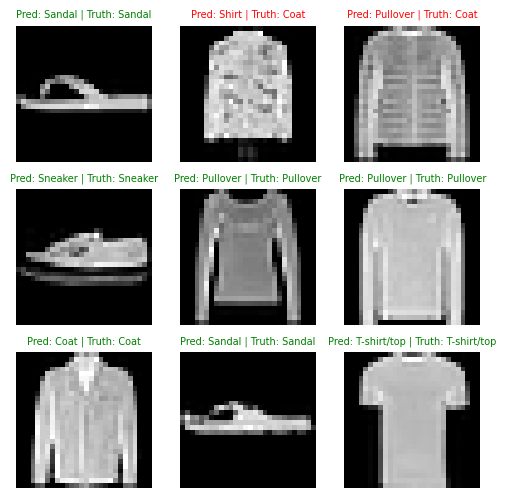

In [122]:
plt.figure(figsize=(6, 6))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(sample.squeeze(), cmap="gray")

    pred_label = train_data.classes[pred_classes[i]]
    truth_label = train_data.classes[test_labels[i]] 

    title_text = f"Pred: {pred_label} | Truth: {truth_label}"

    if pred_label == truth_label:
        plt.title(title_text, fontsize=7, c="green")
    else:
        plt.title(title_text, fontsize=7, c="red")

    plt.axis(False)

In [124]:
y_preds = []
model_2.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    X, y = X.to(device), y.to(device)
    y_logit = model_2(X)
    # logits -> pred probs -> pred labels
    # perform softmax on the logits dimension
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
    y_preds.append(y_pred.cpu())

y_pred_tensor = torch.cat(y_preds)
y_pred_tensor.shape

Making predictions: 100%|██████████| 313/313 [00:00<00:00, 343.17it/s]


torch.Size([10000])

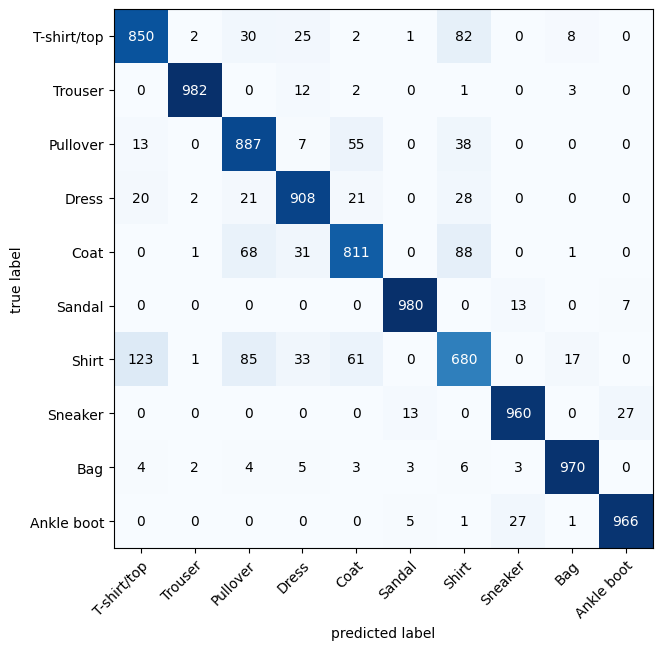

In [127]:
conf_mat = ConfusionMatrix(num_classes=len(train_data.classes), task='multiclass')
conf_mat_tensor = conf_mat(preds=y_pred_tensor,
                           target=test_data.targets)

fig, ax = plot_confusion_matrix(conf_mat=conf_mat_tensor.numpy(),
                                class_names=train_data.classes,
                                figsize=(10, 7))

In [ ]:
torch.save(obj=model_2.state_dict(), f="./model2.pth")